In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import models
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import v2
from torchmetrics.classification import MulticlassAccuracy
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt
import datetime
import pandas as pd

In [2]:
no_epochs = 50
learning_rate = 0.0001
batch_size = 128

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

acc_function = MulticlassAccuracy(num_classes=102, average='micro').to(device)
loss_fn = nn.CrossEntropyLoss()

SEED = 196
np.random.seed(SEED)
generator = torch.Generator().manual_seed(SEED)

cuda:0


In [3]:
# Data Augmentation
train_transforms = v2.Compose([
    v2.RandomRotation(30),
    v2.RandomResizedCrop(224),
    v2.RandomHorizontalFlip(),
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

default_transforms = v2.Compose([
    models.ResNet34_Weights.IMAGENET1K_V1.transforms()
])

flowers_train = datasets.Flowers102(root='./data', split='train', download=True, transform=train_transforms)
flowers_test = datasets.Flowers102(root='./data', split='test', download=True, transform=default_transforms)
flowers_val = datasets.Flowers102(root='./data', split='val', download=True, transform=default_transforms)


In [4]:
def get_data_loader(batch_size):
    train_loader = torch.utils.data.DataLoader(flowers_train, batch_size=batch_size, shuffle=True, generator=generator)
    test_loader = torch.utils.data.DataLoader(flowers_test, batch_size=batch_size, shuffle=True, generator=generator)
    val_loader = torch.utils.data.DataLoader(flowers_val, batch_size=batch_size, shuffle=True, generator=generator)
    return train_loader, test_loader, val_loader

In [5]:
# Early stopping based on accuracy
class AccuracyEarlyStopper:
    def __init__(self, patience=5, min_delta=0.01):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.max_validation_accuracy = 0

    def early_stop(self, validation_accuracy):
        if validation_accuracy > (self.max_validation_accuracy + self.min_delta):
            self.max_validation_accuracy = validation_accuracy
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [6]:
def train(model, optimizer, dataloader, loss_fn=loss_fn):
    running_loss_value = 0
    for images, labels in dataloader:
        optimizer.zero_grad()
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        running_loss_value += loss.item()
        loss.backward()
        optimizer.step()
    return running_loss_value / len(dataloader)

def test_eval(model, dataloader, loss_fn=loss_fn):
    running_loss_value = 0
    running_acc_value = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            acc = acc_function(outputs, labels)
            running_loss_value += loss.item()
            running_acc_value += acc.item()
    running_acc_value /= len(dataloader)
    running_loss_value /= len(dataloader)
    return running_acc_value*100, running_loss_value

def train_eval_test(model, train_dataloader, val_dataloader, test_dataloader, no_epochs=10):
    es = AccuracyEarlyStopper()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_loss_arr, train_acc_arr, eval_loss_arr, eval_acc_arr, train_time = [], [], [], [], []
    for i in range(no_epochs):
        start = datetime.datetime.now()
        train_loss = train(model, optimizer, train_dataloader)
        end = datetime.datetime.now()
        eval_acc, eval_loss = test_eval(model, val_dataloader)
        time_taken = (end-start).total_seconds()
        print(f'Epoch {i+1} Train Loss: {train_loss:>8f}, Eval Accuracy: {eval_acc:>0.2f}%, Eval Loss: {eval_loss:>8f}, Train Time: {time_taken:>0.2f}s')
        train_loss_arr.append(train_loss)
        eval_loss_arr.append(eval_loss)
        eval_acc_arr.append(eval_acc)
        train_time.append(time_taken)
        if es.early_stop(eval_acc):
            print('Early stopping activated')
            break
    test_acc, test_loss = test_eval(model, test_dataloader)
    print(f"Test Accuracy: {test_acc:>0.2f}, Test Loss: {test_loss:>8f}")
    return train_loss_arr, train_acc_arr, eval_loss_arr, eval_acc_arr, test_acc, test_loss, train_time

In [7]:
def get_subset_data_loader(dataset, subset_size, batch_size, generator):
    # Create a random subset of indices
    subset_indices = torch.randperm(len(dataset), generator=generator)[:subset_size].tolist()
    
    # Create a DataLoader for only the subset of data
    subset_data_loader = torch.utils.data.DataLoader(
        dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        sampler=torch.utils.data.SubsetRandomSampler(subset_indices, generator=generator)
    )
    
    return subset_data_loader


def few_shot_train_eval_test(model, train_dataset, val_dataloader, test_dataloader, few_shot_size, no_epochs=10):
    # Get the subset DataLoader for few-shot learning
    train_data_loader = get_subset_data_loader(train_dataset, few_shot_size, batch_size, generator)
    
    # Continue with the rest of your training code
    return train_eval_test(model, train_data_loader, val_dataloader, test_dataloader, no_epochs)

In [8]:
train_data_loader, test_data_loader, val_data_loader = get_data_loader(batch_size)

In [9]:
sample_sizes = [20, 50, 100, 200, 500, 1020]

In [10]:
test_arr, time_arr = [], []
for size in sample_sizes:

    # Apply few-shot learning
    print(f'Few-shot of size {size}')
    few_shot_size = size  # For example, use 20 images per class for few-shot learning
    base_model = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
    base_model.fc = nn.Linear(512, 102)
    base_model = base_model.to(device)

    # Fine-tune the pre-trained model with the few-shot subset
    few_shot_train_acc, few_shot_train_loss, few_shot_eval_loss, few_shot_eval_acc, few_shot_test_acc, few_shot_test_loss, few_shot_train_time = few_shot_train_eval_test(
        base_model, 
        flowers_train,  # Pass the train dataset directly
        val_data_loader, 
        test_data_loader,
        few_shot_size,  # Pass the few-shot size
        no_epochs=no_epochs
    )
    test_arr.append(few_shot_test_acc)
    time_arr.append(np.mean(few_shot_train_time))
    print("\n\n")
    # Now you can compare the results to see how well the model performs with few-shot learning.

Few-shot of size 20
Epoch 1 Train Loss: 4.703498, Eval Accuracy: 1.37%, Eval Loss: 4.817846, Train Time: 14.26s
Epoch 2 Train Loss: 3.877395, Eval Accuracy: 2.55%, Eval Loss: 4.788680, Train Time: 0.22s
Epoch 3 Train Loss: 3.353702, Eval Accuracy: 3.43%, Eval Loss: 4.756506, Train Time: 0.20s
Epoch 4 Train Loss: 2.610750, Eval Accuracy: 4.62%, Eval Loss: 4.724611, Train Time: 0.20s
Epoch 5 Train Loss: 2.106804, Eval Accuracy: 5.88%, Eval Loss: 4.700669, Train Time: 0.20s
Epoch 6 Train Loss: 1.763156, Eval Accuracy: 7.16%, Eval Loss: 4.688875, Train Time: 0.20s
Epoch 7 Train Loss: 1.438465, Eval Accuracy: 8.13%, Eval Loss: 4.675341, Train Time: 0.19s
Epoch 8 Train Loss: 1.104674, Eval Accuracy: 8.72%, Eval Loss: 4.669424, Train Time: 0.20s
Epoch 9 Train Loss: 0.943406, Eval Accuracy: 9.21%, Eval Loss: 4.668248, Train Time: 0.19s
Epoch 10 Train Loss: 0.937050, Eval Accuracy: 10.01%, Eval Loss: 4.676581, Train Time: 0.20s
Epoch 11 Train Loss: 0.678883, Eval Accuracy: 10.39%, Eval Loss: 4.

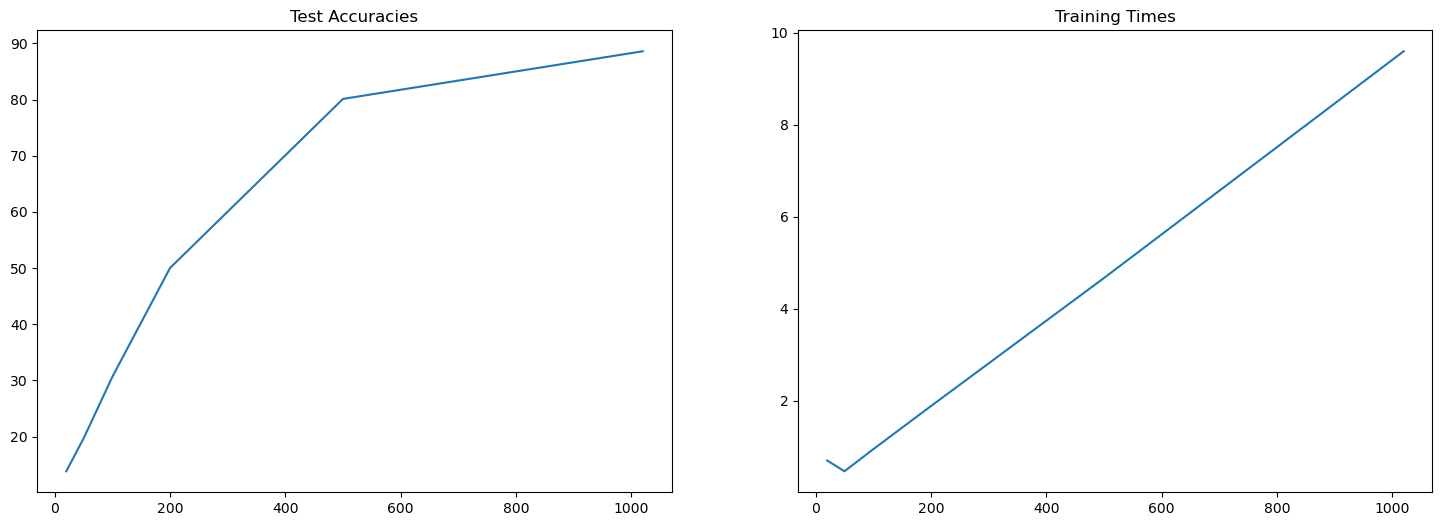

In [11]:
plt.figure(figsize=(18, 6))
plt.subplot(121)
plt.title('Test Accuracies')
plt.plot(sample_sizes, test_arr)
plt.subplot(122)
plt.title('Training Times')
plt.plot(sample_sizes, time_arr)
plt.show()